In [76]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import cProfile
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.cross_validation import train_test_split
from __future__ import division


# Prepare Dataset with same covariance

In [77]:
def dataset_fixed_cov():
    '''Generate 2 Gaussians samples with the same covariance matrix'''
    n, dim = 1000, 2
    np.random.seed(0)
    #a=array.array('i',(0 for i in range(0,1024)))
    #C = np.array([[0., -0.23], [0.83, .23]])
    #C = np.arange
    C = np.array([[0.,-0.23],[0.5,0.23]])
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C) + np.array([1, 1])]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y

# Get the data and plot

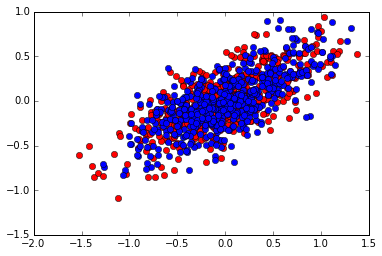

In [78]:
X,y = dataset_fixed_cov()
plt.figure()
plt.plot(X[0:500, 0], X[0:500, 1], 'o', color='red')
plt.plot(X[500:999, 0], X[500:999, 1], 'o', color='blue')


In [79]:
def dataset_cov():
    '''Generate 2 Gaussians samples with different covariance matrices'''
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0., -1.], [2.5, .7]]) * 2.
    print C
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C.T) + np.array([1, 4])]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y

# prepare and normalize data,split

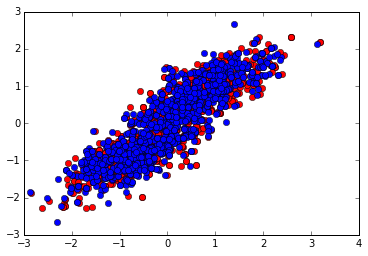

In [80]:
random_num = np.random.randint(X.shape[0], size = X.shape[0])
random_number = 11232015
rng = np.random.RandomState(random_number)
permutation1 = rng.permutation(len(random_num))
random_num = random_num[permutation1]
X = X[random_num]
y = y[random_num]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5,random_state=11)
X_train = preprocessing.scale(X_train,axis = 0, with_mean=True, with_std=True)
X_test = preprocessing.scale(X_test,axis = 0, with_mean=True, with_std=True)
min_max_scaler = preprocessing.MinMaxScaler((-1,1))
y_train = min_max_scaler.fit_transform(y_train)
y_test = min_max_scaler.fit_transform(y_test)

plt.figure()
plt.plot(X_train[:, 0], X_train[:, 1], 'o', color='red')
plt.plot(X_test[:, 0], X_test[:, 1], 'o', color='blue')


# Add one to the column of train data

In [81]:
ones = np.ones((X_train.shape[0]))
ones = np.mat(ones).T
X_train = np.concatenate((X_train,ones),axis=1)
ones = np.ones((X_test.shape[0]))
ones = np.mat(ones).T
X_test = np.concatenate((X_test,ones),axis=1)
print X_train

[[-1.84587394 -2.01638686  1.        ]
 [ 0.0308005   0.85518297  1.        ]
 [-1.36312606 -1.38625757  1.        ]
 ..., 
 [ 0.3440081   0.05724059  1.        ]
 [-1.24575945 -0.98576459  1.        ]
 [ 0.33739785 -0.30801333  1.        ]]


# Some functions

In [82]:
def get_huber_hinge(y,w,x,h):
    t = np.dot(w,np.transpose(x))
    if((y * t) > ( 1 + h)):
        return 0
    elif (abs(1 - (y * t)) <= h):
        return ((( 1 + h - (y * t)) ** 2) / (4 * h))
    elif ((y * t) < (1 - h)):
        return (1 - (y*t))
    else:
        return 0

def grad_huber_hinge(y,w,x,h):
    t = np.dot(w,np.transpose(x))  
    if (y * t) > ( 1 + h):
        return 0
    elif (abs(1 - (y * t)) <= h):
        denominator = np.multiply(y,x) / (2 * h)
        val = (y * t) + (1 + h)
        return np.multiply(denominator,val)
    elif (y * t) < (1 - h):
        return -1 * (np.multiply(y,x))
    else:
        return 0
    

# Analytic Expressions

# #Objective with Huberized hinge-loss

In [83]:
def obj_huber_hinge(y,w,X_in,h):
    #w_2 = np.sum((w ** 2),axis = 1)
    w_2 = np.linalg.norm(w) ** 2
    #vec_get_hinge = np.vectorize(get_huber_hinge)
    #vec_f_x = np.vectorize(f_x)
    #tot_loss = np.sum((vec_get_hinge(y,w,X_in,h)),axis = 0)
    #print y
    #print x_in
    #loss = np.zeros((X_in.shape[0]))
    #for i in range(X_in.shape[0]):
    loss = get_huber_hinge(y,w,X_in,h)
    #tot_loss = np.sum((loss))    
    return (w_2 + loss)
    #return 3
    

# #gradient of huber-hinge-loss

In [84]:
def obj_grad_huber_hinge(y,w,X_in,h):
    w_2 = np.multiply(2,w)
    #print y
    #print X_in
    #loss = np.zeros((X_in.shape[0],w.shape[1]))
    #for i in range(X_in.shape[0]):
    loss = grad_huber_hinge(y,w,X_in,h)
    #vec_get_grad_huber_hinge = np.vectorize(grad_huber_hinge)
    #tot_loss = np.sum((loss),axis = 0)
    #tmp = 1 / X_in.shape[0]
    #tot_loss = np.multiply(tmp,tot_loss)
    return np.add(w_2 , loss)
    #return 3

# Compute_obj

In [85]:
def compute_obj(w,X_in,y,h):
    return obj_huber_hinge(y,w,X_in,h)

In [86]:
def compute_grad(w,X_in,y,h):
    return obj_grad_huber_hinge(y,w,X_in,h)

In [87]:
def update_theta(w,ita,grad):
    #tmp = 1 / np.linalg.norm(grad)
    #u_grad = np.multiply(tmp,grad)
    #ita = -1 * ita
    w = w - ita * grad
    #w = np.add(w,np.multiply(ita,u_grad))
    return w 

# Grad_checker(optional)

# Gradient Descent

In [88]:
def stochastic_gradient_descent(y_in,X_in,y_test,X_test,ita,t,stop_cr):
    w = np.zeros((X_in.shape[1]))
    w = np.matrix(w)
    w_t = np.zeros((t))
    w_t_w = np.zeros((t,X_in.shape[1]))
    train_error = np.zeros((t))
    test_error = np.zeros((t))
    num_iter = t;
    val_error = np.zeros((t))
    random_num = np.random.randint(X_in.shape[0], size = X_in.shape[0])
    random_number = 11232015
    rng = np.random.RandomState(random_number)
    permutation1 = rng.permutation(len(random_num))
    random_num = random_num[permutation1]
    
    for i in range(t):
        if ((i > 0) and (t > X_in.shape[0]) and ( (i % X_in.shape[0]) == 0)):
            random_number = 11292015
            rng = np.random.RandomState(random_number)
            permutation1 = rng.permutation(len(random_num))
            random_num = random_num[permutation1]
            
        x_i = X_in[random_num[i]]         
        x_i = np.matrix(x_i)
        y_i = y_in[random_num[i]]
        w_t_w[i] = w
        w_t[i] = compute_obj(w,x_i,y_i,0.2)
        grad = compute_grad(w,x_i,y_i,0.2)
        w = update_theta(w,ita,grad)
        
        g_x_train = np.sign(np.dot(w,np.transpose(X_in)))
        error_train = np.multiply(y_in,g_x_train)
        wrong_mask_train = error_train <= 0
        tr_er_score =  np.sum(wrong_mask_train) / X_in.shape[0] 
        train_error[i] = tr_er_score 

        g_x_test = np.sign(np.dot(w,np.transpose(X_test)))
        error_test = np.multiply(y_test,g_x_test)
        wrong_mask_test = error_test <= 0
        tt_er_score =  np.sum(wrong_mask_test) / X_test.shape[0] 
        test_error[i] = tt_er_score 
        
        random_num = np.random.randint(X_in.shape[0], size = 1000)
        random_number = 11232015
        rng = np.random.RandomState(random_number)
        permutation1 = rng.permutation(len(random_num))
        random_num = random_num[permutation1]
        val_in = X_in[random_num]
        val_y = y_in[random_num]
        g_x_val = np.sign(np.dot(w,np.transpose(val_in)))
        error_val = np.multiply(val_y,g_x_val)
        wrong_mask_val = error_val <= 0
        vl_er_score =  np.sum(wrong_mask_val) / val_in.shape[0] 
        val_error[i] = vl_er_score 
        
        if stop_cr == 3:
            if i > 10:
                tmp_error = val_error[i - 10 : i - 1]
                print tmp_error
                val = np.amin(tmp_error)
                print val
                if val_error[i] > 0.9 * val:
                    num_iter = i
                    break
    
    plt.plot(np.arange(w_t.shape[0]),w_t,'r',linewidth=2.5, linestyle="-",label = 'Obective function')
    plt.xlabel("Iterations")
    plt.ylabel("Objective function")
    plt.title("Gradient Descent")
    plt.legend(loc='upper right')
    plt.show()
    
    
    plt.plot(np.arange(train_error.shape[0]),train_error,'c',linewidth=2.5, linestyle="-",label = 'train error')
    plt.plot(np.arange(test_error.shape[0]),test_error,'g',linewidth=2.5, linestyle="-",label = 'test error')

    plt.xlabel("Iterations")
    plt.ylabel("% Misclassification Error")
    plt.title("Gradient Descent")
    plt.legend(loc='upper right')
    plt.show()
    
    
    if(stop_cr == 1):
        index = np.argmin(w_t)
    else:
        index = np.argmin(w_t[0:num_iter]) 
    print index
    print w_t[index]
    return w_t_w[index]
    

# My_SVM

In [89]:
def my_svm(X_in,y_in,X_test,y_test):
    max_iter = 1000
    ita = 0.1 * (1.1 ** 3)
    w = stochastic_gradient_descent(y_in,X_in,y_test,X_test,ita,max_iter,1)  
    print w
    #print X_test
    #print y_in

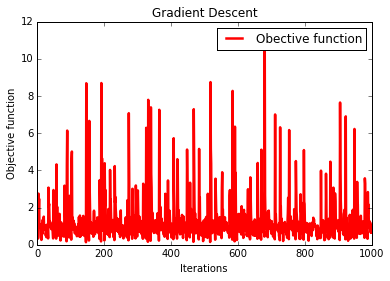

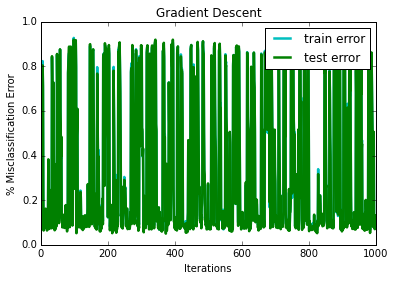

146
0.139057606311
[ 0.2535721   0.24200137 -0.11176807]
--- 0.93323802948 seconds for my_svm---


In [90]:
start_time = time.time()
my_svm(X_train,y_train,X_test,y_test)
print("--- %s seconds for my_svm---" % (time.time() - start_time))